In [4]:
print(os.getcwd())
os.chdir("C:/Users/subbu/OneDrive/Desktop/")
print(os.getcwd())
import os
import cv2

# Dynamically construct the path
base_dir = os.path.abspath("FINALYEAR/media")
image_path = os.path.join(base_dir, "testproj.jpg")

# Check if the file exists
if not os.path.exists(image_path):
    print(f"Image not found at {image_path}.")
else:
    print("Image found!")

    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load the image from {image_path}.")
    else:
        print("Image loaded successfully.")
        # Convert to RGB for display
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # You can proceed with further processing here...





c:\Users\subbu\OneDrive\Desktop\FINALYEAR\backend
C:\Users\subbu\OneDrive\Desktop
Image found!
Image loaded successfully.


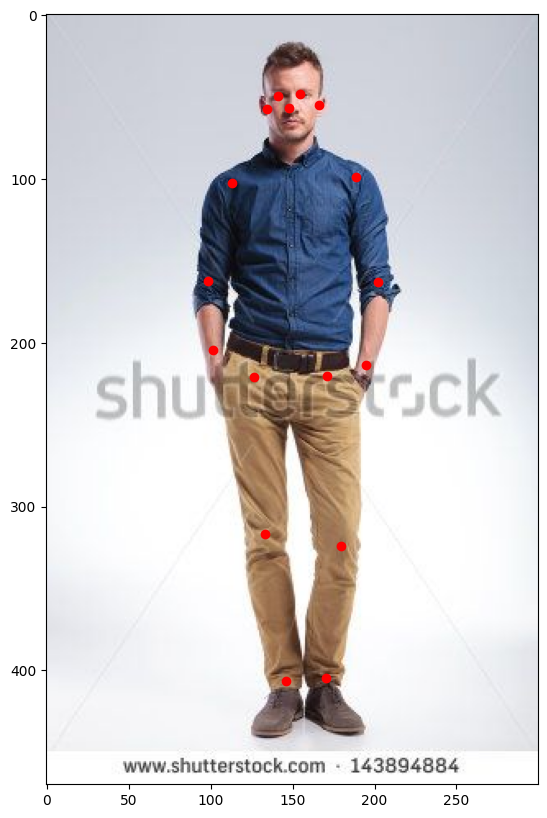

In [21]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

# Load the PoseNet model from TensorFlow Hub
model_url = "https://tfhub.dev/google/movenet/singlepose/lightning/4"
model = hub.load(model_url)

def detect_pose(image):
    # Resize the image to 192x192 for the model
    input_image = tf.image.resize(image, (192, 192))
    input_image = tf.expand_dims(input_image, axis=0)  # Add batch dimension
    input_image = tf.cast(input_image, dtype=tf.int32)

    # Run inference
    outputs = model.signatures['serving_default'](input_image)
    keypoints = outputs['output_0'].numpy()[0, 0, :, :]
    return keypoints

def plot_keypoints(image, keypoints):
    # Plot the detected keypoints on the original image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    for i, (y, x, confidence) in enumerate(keypoints):
        if confidence > 0.5:  # Confidence threshold
            plt.plot(x * image.shape[1], y * image.shape[0], 'ro')

    plt.show()

# Convert the loaded image to RGB (if not already)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect and plot keypoints
keypoints = detect_pose(image_rgb)
plot_keypoints(image_rgb, keypoints)


In [20]:
import cv2
import numpy as np

def overlay_image(background, overlay, x, y, overlay_width, overlay_height):
    """
    Function to overlay the new outfit on the person image.
    """
    # Ensure overlay_width and overlay_height are positive
    if overlay_width <= 0 or overlay_height <= 0:
        raise ValueError(f"Invalid overlay size: width={overlay_width}, height={overlay_height}")

    # Resize the overlay image to match the detected region size
    overlay_resized = cv2.resize(overlay, (overlay_width, overlay_height))

    # Extract the region of interest (ROI) from the background
    roi = background[y:y + overlay_height, x:x + overlay_width]

    # Create a mask of the overlay and its inverse mask
    overlay_gray = cv2.cvtColor(overlay_resized, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(overlay_gray, 1, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)

    # Black-out the area of the outfit in the ROI
    bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

    # Take only the overlay part from the overlay image
    fg = cv2.bitwise_and(overlay_resized, overlay_resized, mask=mask)

    # Put the outfit on the background image and modify the main image
    combined = cv2.add(bg, fg)
    background[y:y + overlay_height, x:x + overlay_width] = combined

    return background

# Load the dress image
dress_image_path = os.path.abspath("FINALYEAR/media/dresss.jpg")
dress_image = cv2.imread(dress_image_path)

if dress_image is None:
    print("Failed to load the dress image.")
else:
    print("Dress image loaded successfully.")

    # Example: Assume shoulders and hips keypoints from PoseNet
    left_shoulder = keypoints[5][:2]  # (y, x)
    right_shoulder = keypoints[6][:2]  # (y, x)
    left_hip = keypoints[11][:2]  # (y, x)
    right_hip = keypoints[12][:2]  # (y, x)

    # Calculate the region where the dress will be placed
    x_min = int(min(left_shoulder[1], right_shoulder[1]))
    x_max = int(max(left_hip[1], right_hip[1]))
    y_min = int(min(left_shoulder[0], right_shoulder[0]))
    y_max = int(max(left_hip[0], right_hip[0]))

    # Calculate width and height for resizing the dress
    overlay_width = x_max - x_min
    overlay_height = y_max - y_min

    # Debugging: Print the overlay dimensions
    print(f"Overlay width: {overlay_width}, Overlay height: {overlay_height}")

    # Check if the dimensions are valid
    if overlay_width <= 0 or overlay_height <= 0:
        print("Error: Invalid overlay dimensions. Please check the keypoints.")
    else:
        # Overlay the dress on the person image
        result_image = overlay_image(image_rgb, dress_image, x_min, y_min, overlay_width, overlay_height)

        # Display the final result
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 10))
        plt.imshow(result_image)
        plt.axis("off")
        plt.show()


Dress image loaded successfully.


IndexError: list index out of range

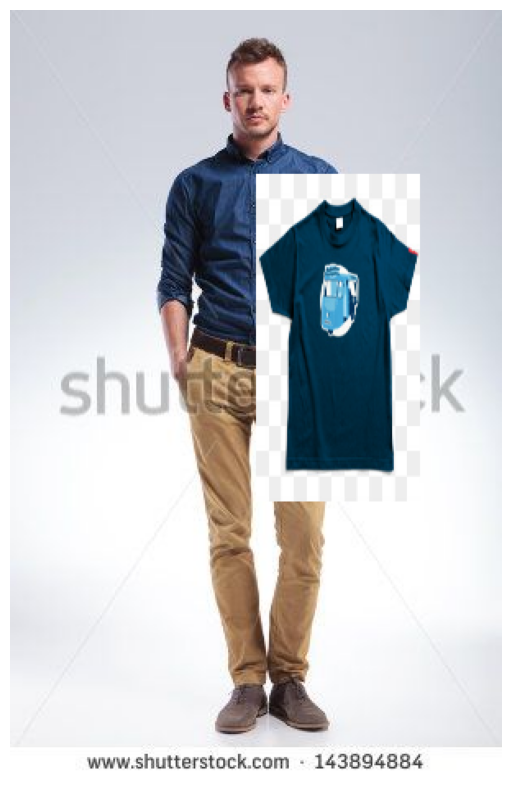

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def overlay_image(background, overlay, x, y, overlay_width, overlay_height):
    """Overlay the new outfit on the person image."""
    if overlay_width <= 0 or overlay_height <= 0:
        raise ValueError("Invalid overlay dimensions.")

    # Resize the overlay (dress) image to match the detected region
    overlay_resized = cv2.resize(overlay, (overlay_width, overlay_height))

    # Extract the region of interest (ROI) from the background
    roi = background[y:y + overlay_height, x:x + overlay_width]

    # Create masks for blending
    overlay_gray = cv2.cvtColor(overlay_resized, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(overlay_gray, 1, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)

    # Black-out the dress area in the ROI
    background_part = cv2.bitwise_and(roi, roi, mask=mask_inv)

    # Keep only the dress part from the overlay
    overlay_part = cv2.bitwise_and(overlay_resized, overlay_resized, mask=mask)

    # Combine both parts
    combined = cv2.add(background_part, overlay_part)
    background[y:y + overlay_height, x:x + overlay_width] = combined

    return background

# Load the person and dress images
person_image_path = "FINALYEAR/media/testproj.jpg"
dress_image_path = "FINALYEAR/media/dresss.jpg"

person_image = cv2.imread(person_image_path)
dress_image = cv2.imread(dress_image_path)

if person_image is None or dress_image is None:
    raise ValueError("Failed to load the images.")

# Example: Keypoints (from PoseNet or other pose model)
keypoints = [
    # y, x positions of keypoints (dummy values for example)
    [100, 150],  # Left shoulder
    [100, 250],  # Right shoulder
    [300, 150],  # Left hip
    [300, 250]   # Right hip
]

# Extract keypoints: shoulders and hips
left_shoulder = keypoints[0]
right_shoulder = keypoints[1]
left_hip = keypoints[2]
right_hip = keypoints[3]

# Calculate the dress overlay area
x_min = int(min(left_shoulder[1], right_shoulder[1]))
x_max = int(max(left_hip[1], right_hip[1]))
y_min = int(min(left_shoulder[0], right_shoulder[0]))
y_max = int(max(left_hip[0], right_hip[0]))

# Calculate width and height for resizing the dress
overlay_width = x_max - x_min
overlay_height = y_max - y_min

if overlay_width <= 0 or overlay_height <= 0:
    raise ValueError("Invalid overlay dimensions. Check the keypoints.")

# Overlay the dress on the person image
result_image = overlay_image(person_image, dress_image, x_min, y_min, overlay_width, overlay_height)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [3]:
import cv2
import tensorflow as tf
import numpy as np

# Load PoseNet model
interpreter = tf.lite.Interpreter(model_path="posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite")
interpreter.allocate_tensors()

# Function to run PoseNet model on the input image
def run_posenet(input_image):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Resize image to the expected input shape of the model
    resized_image = cv2.resize(input_image, (257, 257))
    input_image_tensor = np.expand_dims(resized_image.astype(np.float32), axis=0)
    
    interpreter.set_tensor(input_details[0]['index'], input_image_tensor)
    interpreter.invoke()

    # Get the output keypoints
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

# Load the person's image
image = cv2.imread("person_image.jpg")

# Get PoseNet key points
keypoints = run_posenet(image)

# You will use keypoints like shoulders, hips, etc., to align the clothing image.


ValueError: Could not open 'posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite'.

In [4]:
# Load the clothing image
clothing_image = cv2.imread("dress.png")

# Define source points (in the clothing image) and destination points (on the body)
# Example: Map shoulders of the clothing to the person's shoulders
source_points = np.float32([[0, 0], [clothing_image.shape[1], 0], [0, clothing_image.shape[0]]])
destination_points = np.float32([[keypoints[0][5][0], keypoints[0][5][1]],  # Left shoulder
                                 [keypoints[0][6][0], keypoints[0][6][1]],  # Right shoulder
                                 [keypoints[0][11][0], keypoints[0][11][1]]]) # Left hip

# Get the transformation matrix
transformation_matrix = cv2.getAffineTransform(source_points, destination_points)

# Apply the transformation to warp the clothing image
warped_clothing = cv2.warpAffine(clothing_image, transformation_matrix, (image.shape[1], image.shape[0]))

# Overlay the clothing on the original image
output_image = image.copy()
mask = warped_clothing > 0
output_image[mask] = warped_clothing[mask]

# Display the result
cv2.imshow("Virtual Try-On", output_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


AttributeError: 'NoneType' object has no attribute 'shape'

In [28]:
import cv2
import numpy as np

def overlay_image(background, overlay, x, y, width, height):
    # Resize the overlay to match the target region
    overlay_resized = cv2.resize(overlay, (width, height))

    # Extract the region of interest (ROI) from the background
    roi = background[y:y + height, x:x + width]

    # Create masks for blending
    overlay_gray = cv2.cvtColor(overlay_resized, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(overlay_gray, 1, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)

    # Mask out the area of the person’s clothes in ROI
    background_part = cv2.bitwise_and(roi, roi, mask=mask_inv)

    # Extract only the outfit part from the overlay
    overlay_part = cv2.bitwise_and(overlay_resized, overlay_resized, mask=mask)

    # Combine background and outfit part
    combined = cv2.add(background_part, overlay_part)
    background[y:y + height, x:x + width] = combined

    return background

# Load images
person_img = cv2.imread("testproj.jpg")
dress_img = cv2.imread("dresss.jpg")

if person_img is None and dress_img is None:
    print("Failed to load one of the images.")
else:
    # Example PoseNet keypoints (replace with actual detected keypoints)
    keypoints = [(100, 150), (300, 150), (100, 300), (300, 300)]  # Shoulders and hips

    # Extract coordinates
    left_shoulder, right_shoulder, left_hip, right_hip = keypoints

    # Calculate bounding box for overlay
    x_min = min(left_shoulder[0], right_shoulder[0])
    y_min = min(left_shoulder[1], right_shoulder[1])
    x_max = max(left_hip[0], right_hip[0])
    y_max = max(left_hip[1], right_hip[1])

    # Compute width and height of the overlay
    overlay_width = x_max - x_min
    overlay_height = y_max - y_min

    # Ensure valid overlay dimensions
    if overlay_width > 0 and overlay_height > 0:
        # Overlay the outfit on the person image
        result = overlay_image(person_img, dress_img, x_min, y_min, overlay_width, overlay_height)

        # Display the result
        cv2.imshow("Virtual Try-On", result)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        print("Error: Invalid dimensions. Check keypoints alignment.")


Failed to load one of the images.
